# Build semantic segmentation model using output from GroundTruth and input to SageMaker built in Semantic Segmentation algorithm

This is a demo exercise where I have 11 images and have the following labels

0) Background (I didn't define this label, it is standard)
1) ChipPackets (because I had a small empty packet of salt and vinegar chips handy)
2) Mug (because I had a mug on my desk when taking one of the photos)

There are insufficient images to produce a reliable model; rather the purpose of this notebook is to demonstrate how to:
1) Take output from SageMaker jumpstart and transform it to he required input for the built in algorithm
2) Train a model using SageMaker built in Semantic Segmentation algorithm
3) Stand up a real time endpoint
4) Run inference

## Download all the files from the labeling job from Amazon S3 to a local directory: 

In [ ]:
!aws s3 cp s3://djenny3-sagemaker/semanticsegmentation/outputdataset/ ChipPackets --recursive

## Download the original images from Amazon S3 to a local directory called 'inputimages' which is created in my home directory:

In [45]:
os.chdir(os.path.expanduser("~"))

In [46]:
os.mkdir('inputimages')
!aws s3 cp s3://djenny3-sagemaker/semanticsegmentation/inputimages/ inputimages --recursive --exclude "*" --include "*.jpg"

download: s3://djenny3-sagemaker/semanticsegmentation/inputimages/IMG_0672.jpg to inputimages/IMG_0672.jpg
download: s3://djenny3-sagemaker/semanticsegmentation/inputimages/IMG_0677.jpg to inputimages/IMG_0677.jpg
download: s3://djenny3-sagemaker/semanticsegmentation/inputimages/IMG_0679.jpg to inputimages/IMG_0679.jpg
download: s3://djenny3-sagemaker/semanticsegmentation/inputimages/IMG_0680.jpg to inputimages/IMG_0680.jpg
download: s3://djenny3-sagemaker/semanticsegmentation/inputimages/IMG_0676.jpg to inputimages/IMG_0676.jpg
download: s3://djenny3-sagemaker/semanticsegmentation/inputimages/IMG_0673.jpg to inputimages/IMG_0673.jpg
download: s3://djenny3-sagemaker/semanticsegmentation/inputimages/IMG_0675.jpg to inputimages/IMG_0675.jpg
download: s3://djenny3-sagemaker/semanticsegmentation/inputimages/IMG_0674.jpg to inputimages/IMG_0674.jpg
download: s3://djenny3-sagemaker/semanticsegmentation/inputimages/IMG_0678.jpg to inputimages/IMG_0678.jpg
download: s3://djenny3-sagemaker/sema

Read the manifest file. Get the base name of the original image file (without extension), and rename the annotated png version of the file to have the same base name

In [ ]:
import os
import re
import sys

label_job='chips-semantic-segmentation'
dir_name='ChipPackets'
manifest_path=dir_name+'/'+label_job+'/'+'manifests/output/output.manifest'

file = open(manifest_path, "r") 
txt=file.readlines()
output_path=dir_name+'/'+label_job+'/'+'annotations/consolidated-annotation/output'
S3_name='djenny3-sagemaker/semanticsegmentation/inputimages/'

im_list=[]


for i in range(len(txt)):
    string = txt[i]
    try:
        im_name = re.search(S3_name+'(.+)'+'.jpg', string).group(1)
        im_png=im_name+'.png'
        im_list.append(im_name)
        annotation_name = re.search('output/(.+?)"', string).group(1)
        annotation_path_name = output_path + '/' + annotation_name
        im_png_with_path = output_path + '/' + im_png
        os.rename(annotation_path_name, im_png_with_path)
    except AttributeError:
        pass

## Split the train and validation datasets: 

In [36]:
import numpy as np
from random import sample
  
# Prints list of random items of given length
train_num=len(im_list)*0.8
test_num=len(im_list)*0.2
train_name=sample(im_list,int(train_num))
test_name = list(set(im_list) - set(train_name))

In [37]:
print(train_name)

['IMG_0672', 'IMG_0676', 'IMG_0678', 'IMG_0673', 'IMG_0681', 'IMG_0680', 'IMG_0682', 'IMG_0679']


In [38]:
print(test_name)

['IMG_0677', 'IMG_0674', 'IMG_0675']


## Make a directory in the required format for the semantic segmentation algorithm data channels: 

In [47]:
os.mkdir('./semantic_segmentation_pascalvoc')
#os.chdir('./semantic_segmentation_pascalvoc')
os.mkdir('./semantic_segmentation_pascalvoc/train')
os.mkdir('./semantic_segmentation_pascalvoc/validation')
os.mkdir('./semantic_segmentation_pascalvoc/train_annotation')
os.mkdir('./semantic_segmentation_pascalvoc/validation_annotation')

FileExistsError: [Errno 17] File exists: './semantic_segmentation_pascalvoc'

## Move the training images and their annotations to the created directories.

In [ ]:
import shutil

for i in range(len(train_name)):
    train_im=train_name[i]+'.jpg'
    train_im_path='inputimages/'+train_im
    train_new_path='semantic_segmentation_pascalvoc/train/'+train_im
    print(train_im_path)
    print(train_new_path)
    shutil.move(train_im_path,train_new_path) 
    
    train_annotation=train_name[i]+'.png'
    train_annotation_path=dir_name+'/'+label_job+'/annotations/consolidated-annotation/output/'+train_annotation
    train_annotation_new_path='semantic_segmentation_pascalvoc/train_annotation/'+train_annotation
    print(train_annotation_path)
    print(train_annotation_new_path)
    shutil.move(train_annotation_path,train_annotation_new_path)

## Move the validation images and their annotations to the created directories.

In [55]:
for i in range(len(test_name)):
    val_im=test_name[i]+'.jpg'
    val_im_path='inputimages/'+val_im
    val_new_path='semantic_segmentation_pascalvoc/validation/'+val_im
    print(val_im_path)
    print(val_new_path)
    shutil.move(val_im_path,val_new_path) 
    
    val_annotation=test_name[i]+'.png'
    val_annotation_path=dir_name+'/'+label_job+'/annotations/consolidated-annotation/output/'+val_annotation
    val_annotation_new_path='semantic_segmentation_pascalvoc/validation_annotation/'+val_annotation
    print(val_annotation_path)
    print(val_annotation_new_path)
    shutil.move(val_annotation_path,val_annotation_new_path)

inputimages/IMG_0677.jpg
semantic_segmentation_pascalvoc/validation/IMG_0677.jpg
ChipPackets/chips-semantic-segmentation/annotations/consolidated-annotation/output/IMG_0677.png
semantic_segmentation_pascalvoc/validation_annotation/IMG_0677.png
inputimages/IMG_0674.jpg
semantic_segmentation_pascalvoc/validation/IMG_0674.jpg
ChipPackets/chips-semantic-segmentation/annotations/consolidated-annotation/output/IMG_0674.png
semantic_segmentation_pascalvoc/validation_annotation/IMG_0674.png
inputimages/IMG_0675.jpg
semantic_segmentation_pascalvoc/validation/IMG_0675.jpg
ChipPackets/chips-semantic-segmentation/annotations/consolidated-annotation/output/IMG_0675.png
semantic_segmentation_pascalvoc/validation_annotation/IMG_0675.png


## Upload training and validation datasets to S3

I had issues training because I didn't have the minimum number of images required by the algorithm. At this point I went to the console and created 3 duplicates of each image.
Remember: This exercise is to demonstrate the process of building a semantic segmentation model, not to build an accurate one. Accuracy comes with vastly more unique labelled images than I have used

The method I used was
<code>
cd ~/semantic_segmentation_pascalvoc/train
cp -p image1.jpg image1a.jpg
cp -p image1.jpg image1b.jpg
cp -p image1.jpg image1c.jpg
</code>
...<br>
<code>
cd ~/semantic_segmentation_pascalvoc/train_annotation
cp -p image1.png image1a.png
cp -p image1.png image1b.png
cp -p image1.png image1c.png
</code>
...<br>
<code>
cd ~/semantic_segmentation_pascalvoc/validation
cp -p image1.jpg image1a.jpg
cp -p image1.jpg image1b.jpg
cp -p image1.jpg image1c.jpg
</code>
...<br>
<code>
cd ~/semantic_segmentation_pascalvoc/validation_annotation
cp -p image1.png image1a.png
cp -p image1.png image1b.png
cp -p image1.png image1c.png
</code>
...<br>

In [19]:
local_model_image_dir = "~/semantic_segmentation_pascalvoc"
S3_model_image_dir = "s3://djenny3-sagemaker/semanticsegmentation/model_training_images"

In [97]:
!aws s3 cp {local_model_image_dir}/train {S3_model_image_dir}/train/ --recursive
!aws s3 cp {local_model_image_dir}/train_annotation {S3_model_image_dir}/train_annotation/ --recursive
!aws s3 cp {local_model_image_dir}/validation {S3_model_image_dir}/validation/ --recursive
!aws s3 cp {local_model_image_dir}/validation_annotation {S3_model_image_dir}/validation_annotation/ --recursive

upload: semantic_segmentation_pascalvoc/train/IMG_0672b.jpg to s3://djenny3-sagemaker/semanticsegmentation/model_training_images/train/IMG_0672b.jpg
upload: semantic_segmentation_pascalvoc/train/IMG_0672a.jpg to s3://djenny3-sagemaker/semanticsegmentation/model_training_images/train/IMG_0672a.jpg
upload: semantic_segmentation_pascalvoc/train/IMG_0672.jpg to s3://djenny3-sagemaker/semanticsegmentation/model_training_images/train/IMG_0672.jpg
upload: semantic_segmentation_pascalvoc/train/IMG_0672c.jpg to s3://djenny3-sagemaker/semanticsegmentation/model_training_images/train/IMG_0672c.jpg
upload: semantic_segmentation_pascalvoc/train/IMG_0676.jpg to s3://djenny3-sagemaker/semanticsegmentation/model_training_images/train/IMG_0676.jpg
upload: semantic_segmentation_pascalvoc/train/IMG_0679.jpg to s3://djenny3-sagemaker/semanticsegmentation/model_training_images/train/IMG_0679.jpg
upload: semantic_segmentation_pascalvoc/train/IMG_0678a.jpg to s3://djenny3-sagemaker/semanticsegmentation/model

# Follow the lead from this sample notebook to train the model
https://github.com/aws/amazon-sagemaker-examples/blob/main/introduction_to_amazon_algorithms/semantic_segmentation_pascalvoc/semantic_segmentation_pascalvoc.ipynb

## Create a SageMaker execution role with necessary privileges based on the role used to start this notebook.
## Create a SageMaker session

In [15]:
%%time
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::718520442852:role/service-role/AmazonSageMaker-ExecutionRole-20230120T151120
CPU times: user 777 ms, sys: 76.4 ms, total: 853 ms
Wall time: 1.67 s


## Define the S3 bucket where model artifacts will be stored

In [16]:
# bucket = sess.default_bucket()
bucket = "djenny3-sagemaker"
prefix = "semanticsegmentation"
print(bucket)

djenny3-sagemaker


## Define the location of the algorithm we will use (Built in Semantic Segmentation)

In [17]:
training_image = sagemaker.image_uris.retrieve("semantic-segmentation", sess.boto_region_name)
print(training_image)

544295431143.dkr.ecr.ap-southeast-2.amazonaws.com/semantic-segmentation:1


## Define our data channels

In [20]:
train_channel=S3_model_image_dir+'/train'
train_annotation_channel=S3_model_image_dir+'/train_annotation'
validation_channel=S3_model_image_dir+'/validation'
validation_annotation_channel=S3_model_image_dir+'/validation_annotation'

## Define our output location for the model artifacts

In [21]:
s3_output_location = "s3://{}/{}/output".format(bucket, prefix)
print(s3_output_location)

s3://djenny3-sagemaker/semanticsegmentation/output


## Create an estimator object

In [93]:
ss_estimator = sagemaker.estimator.Estimator(
    training_image,  # Container image URI
    role,  # Training job execution role with permissions to access our S3 bucket
    instance_count=1,
    instance_type="ml.p2.xlarge",
    volume_size=50,  # in GB
    max_run=360000,  # in seconds
    output_path=s3_output_location,
    base_job_name="ss-chippackets",
    sagemaker_session=sess,
)

In [87]:
# Note: To start building from a previously completed training job, we can attach to the existing estimator instead of defining a new one

# ss_estimator = sagemaker.estimator.Estimator.attach("ss-notebook-demo-2020-10-29-07-05-36-516")

## Configure hyperparameters

In [98]:
num_training_samples=len(train_name)
num_training_samples =32
print(num_training_samples)

32


In [105]:
ss_estimator.set_hyperparameters(
    backbone="resnet-50",  # This is the encoder. Other option is resnet-101
    algorithm="fcn",  # This is the decoder. Other options are 'psp' and 'deeplab'
    use_pretrained_model="True",  # Use the pre-trained model.
    crop_size=240,  # Size of image random crop.
    num_classes=3,  # Pascal has 21 classes. This is a mandatory parameter.
    epochs=30,  # Number of epochs to run.
    learning_rate=0.0001,
    optimizer="rmsprop",  # Other options include 'adam', 'rmsprop', 'nag', 'adagrad'.
    lr_scheduler="poly",  # Other options include 'cosine' and 'step'.
    mini_batch_size=16,  # Setup some mini batch size.
    validation_mini_batch_size=12,
    early_stopping=True,  # Turn on early stopping. If OFF, other early stopping parameters are ignored.
    early_stopping_patience=2,  # Tolerate these many epochs if the mIoU doens't increase.
    early_stopping_min_epochs=10,  # No matter what, run these many number of epochs.
    num_training_samples=num_training_samples,  # This is a mandatory parameter
)

## Define how our data will be distributed over multiple nodes (if using distributed training), and define our input data channels

We can optionally define a data map in case we are not happy with the default order

In [106]:
distribution = "FullyReplicated"

data_channels = {
    "train": sagemaker.inputs.TrainingInput(train_channel, distribution=distribution),
    "validation": sagemaker.inputs.TrainingInput(validation_channel, distribution=distribution),
    "train_annotation": sagemaker.inputs.TrainingInput(
        train_annotation_channel, distribution=distribution
    ),
    "validation_annotation": sagemaker.inputs.TrainingInput(
        validation_annotation_channel, distribution=distribution
    ),
    # 'label_map': label_map_channel
}

## Initiate training

In [107]:
ss_estimator.fit(data_channels, logs=True)

2023-01-27 09:07:57 Starting - Starting the training job...
2023-01-27 09:08:22 Starting - Preparing the instances for trainingProfilerReport-1674810476: InProgress
.........
2023-01-27 09:09:56 Downloading - Downloading input data...
2023-01-27 09:10:16 Training - Downloading the training image...........................
2023-01-27 09:14:58 Training - Training image download completed. Training in progress........Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Fri Jan 27 09:16:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         

In [13]:
# Note: You can also 'attach' to a previously completed training job if, for example, you had to re-start the
# notebook and would like to skip straight to `ss_estimator.deploy()` later on:

# ss_estimator = sagemaker.estimator.Estimator.attach("ss-notebook-demo-2020-10-29-07-05-36-516")

In [22]:
ss_estimator = sagemaker.estimator.Estimator.attach("ss-chippackets-2023-01-27-09-07-56-732")


2023-01-27 09:23:20 Starting - Preparing the instances for training
2023-01-27 09:23:20 Downloading - Downloading input data
2023-01-27 09:23:20 Training - Training image download completed. Training in progress.
2023-01-27 09:23:20 Uploading - Uploading generated training model
2023-01-27 09:23:20 Completed - Training job completed


# Deployment

In [23]:
ss_predictor = ss_estimator.deploy(initial_instance_count=1, instance_type="ml.c5.xlarge")

-----------------!

# Inference

Because this is a dummy test (way too few training images), I will run inference against one of the images used in training. Normally you would use an image that has not been seen by the model

In [9]:
inference_image1='semantic_segmentation_pascalvoc/train/IMG_0672.jpg'

In [7]:
import os
os.chdir(os.path.expanduser("~"))
os.mkdir('./inference_data')

FileExistsError: [Errno 17] File exists: './inference_data'

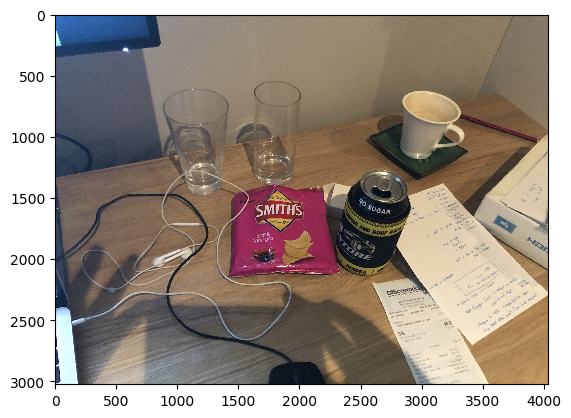

In [10]:
from matplotlib import pyplot as plt
import PIL

%matplotlib inline

filename = "inference_data/inference_image1_resized.jpg"
width = 800

im = PIL.Image.open(inference_image1)

plt.imshow(im)
plt.show()



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  This is separate from the ipykernel package so we can avoid doing imports until


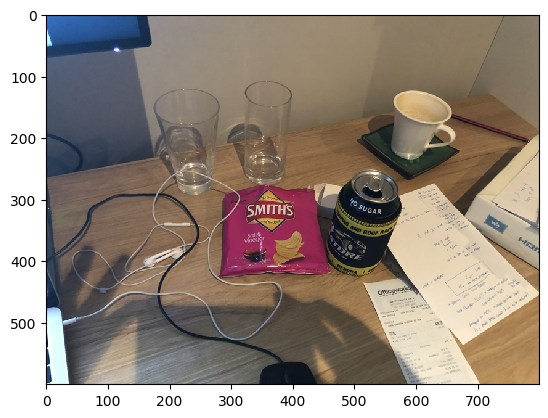

In [11]:
aspect = im.size[0] / im.size[1]

im.thumbnail([width, int(width / aspect)], PIL.Image.ANTIALIAS)
im.save(filename, "JPEG")

plt.imshow(im)
plt.show()

In [24]:
from PIL import Image
import numpy as np


class ImageDeserializer(sagemaker.deserializers.BaseDeserializer):
    """Deserialize a PIL-compatible stream of Image bytes into a numpy pixel array"""

    def __init__(self, accept="image/png"):
        self.accept = accept

    @property
    def ACCEPT(self):
        return (self.accept,)

    def deserialize(self, stream, content_type):
        """Read a stream of bytes returned from an inference endpoint.
        Args:
            stream (botocore.response.StreamingBody): A stream of bytes.
            content_type (str): The MIME type of the data.
        Returns:
            mask: The numpy array of class labels per pixel
        """
        try:
            return np.array(Image.open(stream))
        finally:
            stream.close()


ss_predictor.deserializer = ImageDeserializer(accept="image/png")

In [25]:
ss_predictor.serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")

with open(filename, "rb") as imfile:
    imbytes = imfile.read()

## Run inference against our endpoint

In [27]:
%%time

cls_mask = ss_predictor.predict(imbytes)

print(type(cls_mask))
print(cls_mask.shape)

<class 'numpy.ndarray'>
(600, 800)
CPU times: user 20.8 ms, sys: 1.38 ms, total: 22.2 ms
Wall time: 6.75 s


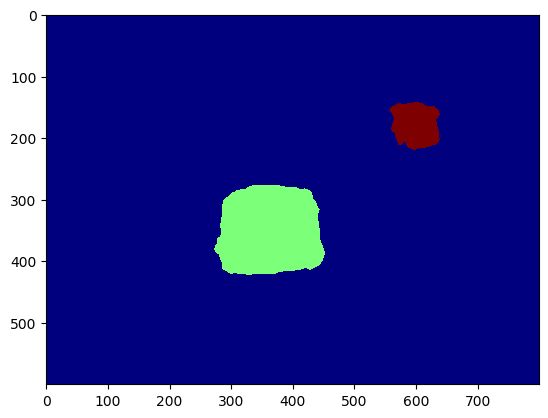

In [28]:
plt.imshow(cls_mask, cmap="jet")
plt.show()

In [36]:
img = Image.fromarray(cls_mask)
#img.save('inference_data/image_mask.png')
img.show()

In [32]:
#try:
#    from PIL import Image
#except ImportError:
#    import Image

new_img = Image.blend(im, cls_mask, 0.5)
new_img.save("new.png","PNG")

AttributeError: 'numpy.ndarray' object has no attribute 'load'

## Superimpose image with mask

In [43]:
imarray = np.array(PIL.Image.open(filename)) / 255.0  # Convert image pixels from 0-255 to 0-1
hilitecol = np.array((0.0, 1.0, 1.0, 1.0))  # Cyan, 100% opacity (RGBAlpha 0-1 range)

In [39]:
target_cls_id = 1 # chip_packets

In [44]:
print(imarray.shape)

(600, 800, 3)


In [40]:
# Construct a mask with alpha channel taken from the model result:
hilitemask = np.tile(hilitecol[np.newaxis, np.newaxis, :], list(imarray.shape[:2]) + [1])
hilitemask[:, :, 3] = cls_mask[target_cls_id, :, :]

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [41]:
print(cls_mask.shape)

(600, 800)


In [42]:
print(imarray.shape)

(600, 800, 3)


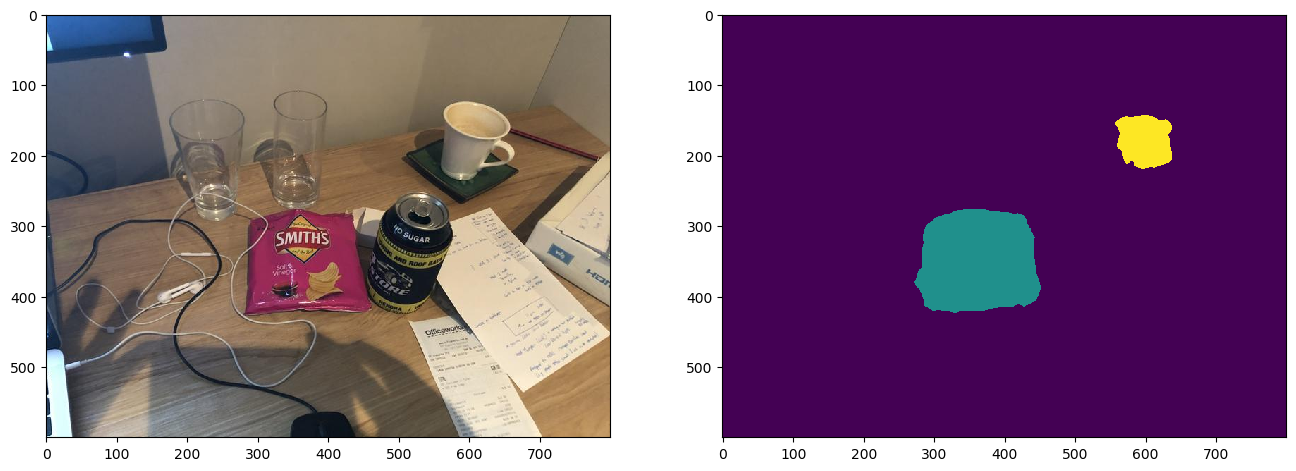

In [51]:
# Overlay the two images:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16, 6))
ax1.imshow(imarray)
ax2.imshow(cls_mask)
plt.show()

# Delete the endpoint

In [52]:
ss_predictor.delete_endpoint()